In [1]:
%matplotlib widget
from bmcs_cross_section.api import MKappa, EC2
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# EC2, eq. (3.14)

sig_c1, sig_c2, sig_c3, eps_cu1, b, c, d, A_f, f_fu, E_f = \
 sp.symbols('sigma_c1 sigma_c2 sigma_c3, varepsilon_cu1, b, c, d, A_f, f_{fu}, E_f', real=True, nonnegative=True)
eps_cy, eps_cu, eps, E_cc, f_cm = \
sp.symbols('varepsilon_cy, varepsilon_cu, varepsilon, E_cc, f_cm', real=True, nonnegative=True)

k = 1.05 * E_cc * eps_cy / f_cm
eta = eps / eps_cy
sig_c = f_cm * (k*eta - eta**2)/(1+eta*(k-2))

sig_c_eps_ = sp.Piecewise(
        (0, eps > eps_cu),
        (sig_c, eps > 0),
        (0, True)
)

In [3]:
from scipy.optimize import minimize

f_cms = np.array([ 20.,  24.,  28.,  33.,  38.,  43.,  48.,  53.,  58.,  63.,  68., 78.,  88.,  98., 108.])

# f_cms = np.array([60])
    
def get_sig_eps(f_cm_, eps_trial_list, branch=1):
    eps_cy_ = EC2.get_eps_c1(f_cm_ - 8)
    eps_cu_ = EC2.get_eps_cu1(f_cm_- 8)
    
    # supress invalid solutions
    for eps_val in eps_trial_list:
        if eps_val < 0 or eps_val > 1:
            return 9999999
        
#     for eps_val in eps_trial_list:
#         if eps_val < 0 or eps_val > eps_cu_:
#             return None
    
    sig_c_eps = sig_c_eps_.subs({E_cc:EC2.get_E_cm(f_cm_ - 8), eps_cy:eps_cy_, 
                                f_cm:EC2.get_f_cm(f_cm_ - 8), eps_cu:eps_cu_})
    get_sig = sp.lambdify(eps, sig_c_eps, 'numpy')
    if branch == 1:
        eps_fine = np.linspace(0, eps_cy_, 500)
        #     eps_coarse = np.concatenate(([0], [eps_trial_list[0]], [eps_cy_], [eps_trial_list[1]], [eps_cu_]))
        eps_coarse = np.concatenate(([0], [eps_trial_list[0] * eps_cy_], [eps_cy_]))
    elif branch == 2:
        eps_fine = np.linspace(eps_cy_, eps_cu_, 300)
        eps_coarse = np.concatenate(([eps_cy_], [eps_cu_]))
    
    sig_fine = get_sig(eps_fine)
    sig_coarse = get_sig(eps_coarse)
    
    return eps_fine, sig_fine, eps_coarse, sig_coarse

def area_diff_eps_mini(eps_trial_list, f_cm_=None, branch=1):
    eps_sig = get_sig_eps(f_cm_, eps_trial_list, branch)
    if eps_sig is None:
        return 99999999
    eps_fine, sig_fine, eps_coarse, sig_coarse = eps_sig
    area_diff = np.abs(np.trapz(y=sig_fine, x=eps_fine) - np.trapz(y=sig_coarse, x=eps_coarse))

    return area_diff

def area_diff_sig_scale_mini(sig_scales, eps_trial_list=None, f_cm_=None, branch=1):
    for sig_scale in sig_scales:
        if sig_scale < 0 or sig_scale > 10:
            return 9999999
    
    eps_fine, sig_fine, eps_coarse, sig_coarse = get_sig_eps(f_cm_, eps_trial_list, branch)
    if branch == 1:
        sig_coarse[1] *= sig_scales[0]
        if sig_coarse[1] > f_cm_:
            return 9999999
    elif branch == 2:
        sig_coarse[-1] *= sig_scales[0]
        if sig_coarse[-1] > f_cm_:
            return 9999999

    area_diff = np.abs(np.trapz(y=sig_fine, x=eps_fine) - np.trapz(y=sig_coarse, x=eps_coarse))
    
#     print('area_diff=', area_diff)
    return area_diff
 

c_section, b_section = 150, 400

def minimize_area_diff():
    result = np.zeros((len(f_cms), 4))
    
    # branch 1
    for i, f_cm_ in enumerate(f_cms):
        branch = 1 
        res1 = minimize(area_diff_eps_mini, np.array([0]), tol=1e-12, args=(f_cm_, branch))
        smallest_diff1 = res1.fun
        print('smallest_diff1=', smallest_diff1)
        print('F_c_diff [N] ≈', np.round(smallest_diff1 * (c_section / EC2.get_eps_cu1(f_cm_ - 8)) * b_section, 3))
        
        res2 = minimize(area_diff_sig_scale_mini, np.array([1.]), tol=1e-12, args=(np.sort(res1.x), f_cm_, branch))
        smallest_diff2 = res2.fun
        print('smallest_diff2=', smallest_diff2)
        print('F_c_diff [N] ≈', np.round(smallest_diff2 * (c_section / EC2.get_eps_cu1(f_cm_ - 8)) * b_section, 3))
        
        branch = 2
        res3 = minimize(area_diff_sig_scale_mini, np.array([1.]), tol=1e-12, args=(np.sort(res1.x), f_cm_, branch))
        smallest_diff3 = res3.fun
        print('smallest_diff3=', smallest_diff3)
        print('F_c_diff [N] ≈', np.round(smallest_diff2 * (c_section / EC2.get_eps_cu1(f_cm_ - 8)) * b_section, 3))
        
        print('-----------------------------')
        sol1 = res1.x
        sol2 = res2.x
        sol3 = res3.x
        print(sol1)
        result[i:] = np.concatenate(([f_cm_], np.sort(sol1), np.sort(sol2), np.sort(sol3)))
    return result

result = minimize_area_diff()
result

smallest_diff1= 0.0017845824085170568
F_c_diff [N] ≈ 30592.841
smallest_diff2= 9.755401694788723e-11
F_c_diff [N] ≈ 0.002
smallest_diff3= 6.830130905299825e-11
F_c_diff [N] ≈ 0.002
-----------------------------
[0.44789506]
smallest_diff1= 0.0021539913118004753
F_c_diff [N] ≈ 36925.565
smallest_diff2= 1.252167119991654e-10
F_c_diff [N] ≈ 0.002
smallest_diff3= 4.294761074552511e-11
F_c_diff [N] ≈ 0.002
-----------------------------
[0.46287631]
smallest_diff1= 0.0025131189684338487
F_c_diff [N] ≈ 43082.039
smallest_diff2= 1.539655347659874e-10
F_c_diff [N] ≈ 0.003
smallest_diff3= 4.427858774080917e-11
F_c_diff [N] ≈ 0.003
-----------------------------
[0.47622923]
smallest_diff1= 0.002945016590974736
F_c_diff [N] ≈ 50485.999
smallest_diff2= 1.7022202397631858e-10
F_c_diff [N] ≈ 0.003
smallest_diff3= 2.4636681583700692e-11
F_c_diff [N] ≈ 0.003
-----------------------------
[0.4912546]
smallest_diff1= 0.0033558458456816667
F_c_diff [N] ≈ 57528.786
smallest_diff2= 5.839509431559975e-11
F_c

array([[ 20.        ,   0.44789506,   1.13381005,   1.25393379],
       [ 24.        ,   0.46287631,   1.12742087,   1.2521215 ],
       [ 28.        ,   0.47622923,   1.12161289,   1.24830095],
       [ 33.        ,   0.4912546 ,   1.11499021,   1.24152433],
       [ 38.        ,   0.50490385,   1.10892868,   1.23315806],
       [ 43.        ,   0.51751462,   1.10331766,   1.22365821],
       [ 48.        ,   0.52931887,   1.09807755,   1.21334235],
       [ 53.        ,   0.54048383,   1.09314897,   1.20244302],
       [ 58.        ,   0.55113476,   1.0884863 ,   1.19113778],
       [ 63.        ,   0.56136872,   1.08405368,   1.06009764],
       [ 68.        ,   0.57126297,   1.07982235,   1.02116994],
       [ 78.        ,   0.59027457,   1.07187387,   1.00208012],
       [ 88.        ,   0.60925116,   1.0642266 ,   1.00000075],
       [ 98.        ,   0.64275529,   1.0515758 ,   1.        ],
       [108.        ,   0.67931527,   1.03922995,   1.        ]])

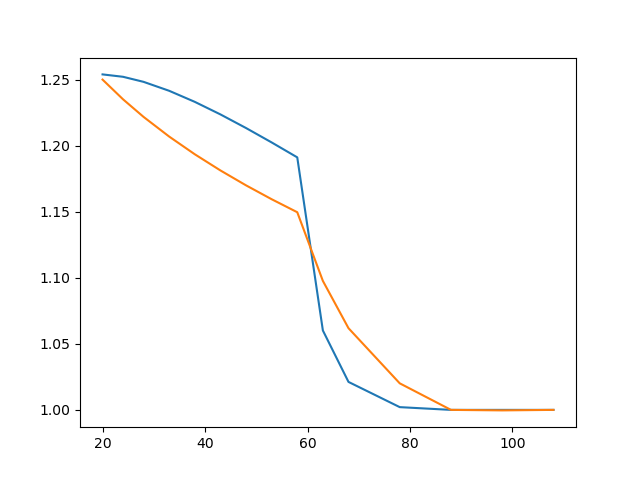

In [4]:
fig1, ax1 = plt.subplots()
eps_diff = np.zeros(len(f_cms))
for i, f_cm_val in enumerate(f_cms):
#     eps_diff[i] = (3.5 if f_cm_val <50 else 2.8 + 27 * ((98 - f_cm_val) / 100) ** 4) - min(2.8, 0.7 * f_cm_val ** 0.31)
    eps_diff[i] = EC2.get_eps_cu1(f_cm_val - 8) - EC2.get_eps_c1(f_cm_val - 8)

eps_diff_scaled = (eps_diff - eps_diff[0])/(eps_diff[-1] - eps_diff[0]) * (1 - 1.25) + 1.25

ax1.plot(result[:, 0], result[:, 3]) # sig_eps_cu_scaled / sig_eps_cu_exact
ax1.plot(result[:, 0], eps_diff_scaled)
# ax1.plot(result[:, 0], sig_eps_cu_scaled)

In [5]:
m1, p1 = np.polyfit(result[:, 0], result[:, 1], 1)
eps_cy_p1_scale = m1 * f_cm + p1 # must be <= 1

m2, p2 = np.polyfit(result[:, 0], result[:, 2], 1)
sig_cy_p1_scale = m2 * f_cm + p2  # must be >= 1

sig_eps_cu_scaled = 1.000964 + (1.235655 - 1.000964)/(1 + (f_cm/60.73773)**24.71828) # must be >= 1
# last one obtained from https://mycurvefit.com/, by 4PL Symmetrical sigmoidal fitting

In [6]:
get_eps_cy_p1_scale = sp.lambdify(f_cm, eps_cy_p1_scale, 'numpy')
get_sig_cy_p1_scale = sp.lambdify(f_cm, sig_cy_p1_scale, 'numpy')

Text(0, 0.5, 'sig_cy_p1_scale')

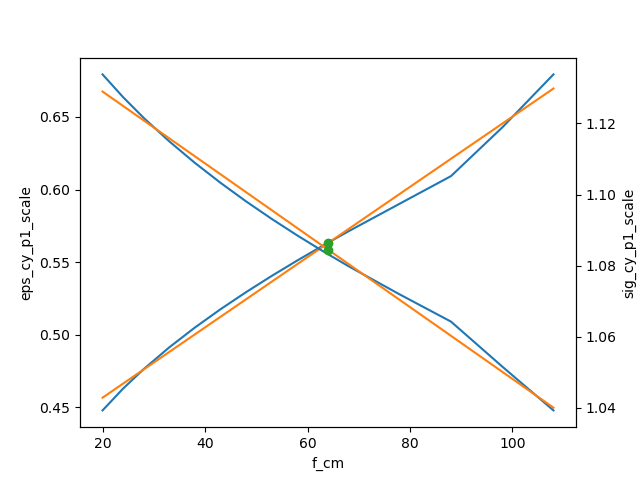

In [7]:
fig1, ax1 = plt.subplots()
f_cm_mid = (result[:, 0][-1] + result[:, 0][0])/2
ax1.set_xlabel('f_cm')
ax1.set_ylabel('eps_cy_p1_scale')

ax1.plot(result[:, 0], result[:, 1]) # eps_cy_p1_scale / eps_cy
ax1.plot(result[:, 0], get_eps_cy_p1_scale(result[:, 0]))
eps_cy_p1_scale_mid = np.interp(f_cm_mid, result[:, 0], get_eps_cy_p1_scale(result[:, 0]))
ax1.plot(f_cm_mid, eps_cy_p1_scale_mid, 'o')

ax2 = ax1.twinx()
ax2.plot(result[:, 0], result[:, 2]) # sig_cy_p1_scale, (sig_cy_p1_scaled = sig_cy_p1_scale * sig_cy_p1_exact)
ax2.plot(result[:, 0], get_sig_cy_p1_scale(result[:, 0]))
sig_cy_p1_scale_mid = np.interp(f_cm_mid, result[:, 0], get_sig_cy_p1_scale(result[:, 0]))
ax2.plot(f_cm_mid, sig_cy_p1_scale_mid, 'o')
ax2.set_ylabel('sig_cy_p1_scale')

# ax1.plot(result[:, 0], result[:, 3]) # sig_eps_cu_scale, (sig_eps_cu_scaled = sig_eps_cu_scale * sig_eps_cu_exact)

In [8]:
eps_cy_p1_scale_mid, sig_cy_p1_scale_mid # Use these, easier than doing a linear equation

(0.5631233569695422, 1.0844887182944656)

0.00018346397749549603
F_c_diff [kN] ≈ 3.65
F_c_diff [%] ≈ 0.13


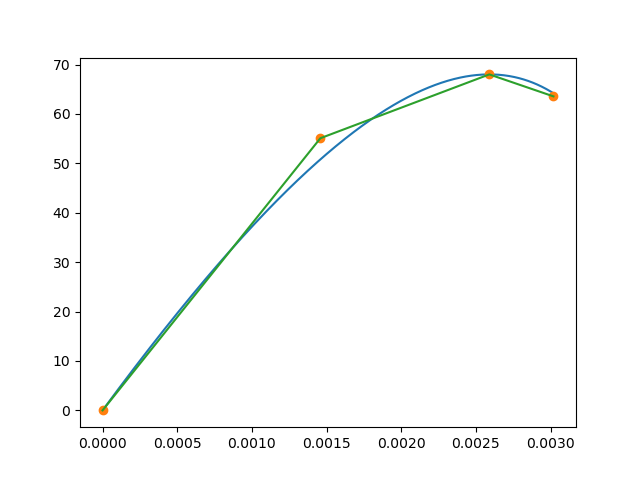

In [9]:
fig, ax = plt.subplots()

for f_cm_ in [68]: # f_cms:
    eps_cy_ = EC2.get_eps_c1(f_cm_ - 8)
    eps_cu_ = EC2.get_eps_cu1(f_cm_ - 8)

    eps_fine = np.linspace(0, eps_cu_, 500)

    sig_c_eps = sig_c_eps_.subs({E_cc:EC2.get_E_cm(f_cm_ - 8), eps_cy:eps_cy_, 
                                f_cm:EC2.get_f_cm(f_cm_ - 8), eps_cu:eps_cu_})

    get_sig = sp.lambdify(eps, sig_c_eps, 'numpy')
    sig_fine = get_sig(eps_fine)

    
    ax.plot(eps_fine, sig_fine)
    
    result_for_f_ck = np.copy(result[np.argwhere(result[:, 0]==f_cm_)[0][0]])
    result_for_f_ck[1] = eps_cy_p1_scale_mid
    result_for_f_ck[2] = sig_cy_p1_scale_mid
    
    eps_coarse = np.concatenate(([0], [result_for_f_ck[1] * eps_cy_], [eps_cy_], [eps_cu_]))
    sig_coarse = get_sig(eps_coarse)

#     result_for_f_ck[3] = (sig_coarse[-2] + sig_coarse[-1]) / 2

    sig_coarse[1] *= result_for_f_ck[2]
    sig_coarse[-1] = (sig_coarse[-2] + sig_coarse[-1]) / 2.08 

    ax.plot(eps_coarse, sig_coarse, 'o')
    ax.plot(eps_coarse, sig_coarse)
    
    area_diff = np.abs(np.trapz(y=sig_fine, x=eps_fine) - np.trapz(y=sig_coarse, x=eps_coarse))
    print(area_diff)
    c, b = 150, 400
    F_c_diff = np.round(area_diff * (c / EC2.get_eps_cu1(f_cm_ - 8)) * b/1000, 2)
    F_c_total = np.trapz(y=sig_fine, x=eps_fine) * (c / EC2.get_eps_cu1(f_cm_ - 8)) * b/1000
    print('F_c_diff [kN] ≈', F_c_diff)
    print('F_c_diff [%] ≈', np.round(100 * F_c_diff/F_c_total, 2))
    

# fig.show()

## Deriving equations for the three linearized parts
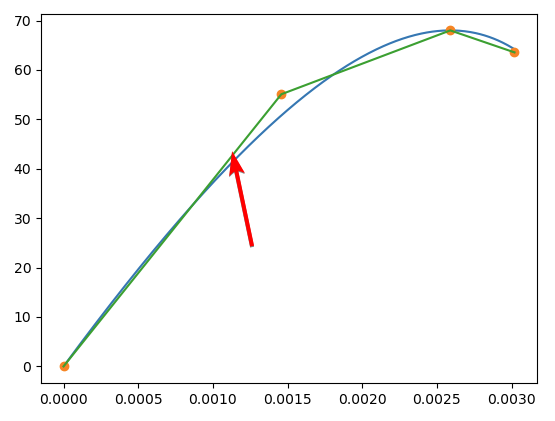

In [10]:
substitute_E_cc_and_eps_cy = False

if substitute_E_cc_and_eps_cy:
    E_cm = 22000 * (f_cm / 10) ** 0.3
    # WARNING, TODO: Instead use 0.001 * sp.Min(0.7 * f_cm ** 0.31, 2.8) ??
    eps_c1 = 0.001 * 0.7 * f_cm ** 0.31
else:
    E_cm = E_cc
    eps_c1 = eps_cy
    
# eps_cy_p1 = eps_cy_p1_scale * eps_c1
eps_cy_p1 = eps_cy_p1_scale_mid * eps_c1

sig_cy_p1 = sp.simplify(sig_c.subs({eps:eps_cy_p1, E_cc:E_cm, eps_cy:eps_c1}))

# sig_cy_p1 =  sig_cy_p1_scale * sig_cy_p1
sig_cy_p1 = sig_cy_p1_scale_mid * sig_cy_p1
sig_cy_p1

1.08448871829447*f_cm*(0.591279524818019*E_cc*varepsilon_cy - 0.317107915164646*f_cm)/(0.591279524818019*E_cc*varepsilon_cy - 0.126246713939084*f_cm)

In [11]:
eps_cy_p1_scale.subs({f_cm:100})

0.650234112568268

In [12]:
sig_c_part_1_line = sp.Line(sp.Point(0, 0), sp.Point(eps_cy_p1, sig_cy_p1))

sig_c1_eq = sig_c_part_1_line.equation(x=eps, y=sig_c1)
sig_c1_ = sp.solve(sig_c1_eq, sig_c1)[0]
sig_c1_

180748119715745*f_cm*varepsilon*(591279524818019*E_cc*varepsilon_cy - 317107915164646*f_cm)/(93853892828257*varepsilon_cy*(591279524818019*E_cc*varepsilon_cy - 126246713939084*f_cm))

In [13]:
sig_c2_line = sp.Line(sp.Point(eps_cy_p1, sig_cy_p1), sp.Point(eps_c1, f_cm))
sig_c2_eq = sig_c2_line.equation(x=eps, y=sig_c2)
sig_c2_ = sp.solve(sig_c2_eq, sig_c2)[0]
sig_c2_

f_cm*(-24978224602818845141402027465*E_cc*varepsilon*varepsilon_cy + 154136331550389104339964138816*E_cc*varepsilon_cy**2 + 108826621269427233621180653810*f_cm*varepsilon - 136403741559094007035264964046*f_cm*varepsilon_cy)/(218438321515229*varepsilon_cy*(591279524818019*E_cc*varepsilon_cy - 126246713939084*f_cm))

In [14]:
sig_cy_p3 = sp.simplify(sig_c.subs({eps:eps_cu1, E_cc:E_cm, eps_cy:eps_c1}))
sig_cy_p3 = (sig_cy_p3 + f_cm) / 2.08
sig_cy_p3

0.480769230769231*f_cm*varepsilon_cu1*(1.05*E_cc*varepsilon_cy**2 - f_cm*varepsilon_cu1)/(varepsilon_cy*(f_cm*varepsilon_cy + varepsilon_cu1*(1.05*E_cc*varepsilon_cy - 2*f_cm))) + 0.480769230769231*f_cm

In [15]:
sig_c3_line = sp.Line(sp.Point(eps_c1, f_cm), sp.Point(eps_cu1, sig_cy_p3))

sig_c3_eq = sig_c3_line.equation(x=eps, y=sig_c3)
sig_c3_ = sp.solve(sig_c3_eq, sig_c3)[0]
sig_c3_

f_cm*(-21*E_cc*varepsilon*varepsilon_cu1*varepsilon_cy**2 + 546*E_cc*varepsilon_cu1**2*varepsilon_cy**2 - 525*E_cc*varepsilon_cu1*varepsilon_cy**3 - 250*f_cm*varepsilon*varepsilon_cu1**2 + 540*f_cm*varepsilon*varepsilon_cu1*varepsilon_cy - 270*f_cm*varepsilon*varepsilon_cy**2 - 790*f_cm*varepsilon_cu1**2*varepsilon_cy + 1020*f_cm*varepsilon_cu1*varepsilon_cy**2 - 250*f_cm*varepsilon_cy**3)/(26*varepsilon_cy*(21*E_cc*varepsilon_cu1**2*varepsilon_cy - 21*E_cc*varepsilon_cu1*varepsilon_cy**2 - 40*f_cm*varepsilon_cu1**2 + 60*f_cm*varepsilon_cu1*varepsilon_cy - 20*f_cm*varepsilon_cy**2))

In [16]:
eq = sp.Piecewise(
    (sig_c1_, eps <= eps_cy_p1), 
    (sig_c2_, eps <= eps_c1), 
    (sig_c3_, True)
)
eq

Piecewise((180748119715745*f_cm*varepsilon*(591279524818019*E_cc*varepsilon_cy - 317107915164646*f_cm)/(93853892828257*varepsilon_cy*(591279524818019*E_cc*varepsilon_cy - 126246713939084*f_cm)), varepsilon <= 0.563123356969542*varepsilon_cy), (f_cm*(-24978224602818845141402027465*E_cc*varepsilon*varepsilon_cy + 154136331550389104339964138816*E_cc*varepsilon_cy**2 + 108826621269427233621180653810*f_cm*varepsilon - 136403741559094007035264964046*f_cm*varepsilon_cy)/(218438321515229*varepsilon_cy*(591279524818019*E_cc*varepsilon_cy - 126246713939084*f_cm)), varepsilon <= varepsilon_cy), (f_cm*(-21*E_cc*varepsilon*varepsilon_cu1*varepsilon_cy**2 + 546*E_cc*varepsilon_cu1**2*varepsilon_cy**2 - 525*E_cc*varepsilon_cu1*varepsilon_cy**3 - 250*f_cm*varepsilon*varepsilon_cu1**2 + 540*f_cm*varepsilon*varepsilon_cu1*varepsilon_cy - 270*f_cm*varepsilon*varepsilon_cy**2 - 790*f_cm*varepsilon_cu1**2*varepsilon_cy + 1020*f_cm*varepsilon_cu1*varepsilon_cy**2 - 250*f_cm*varepsilon_cy**3)/(26*varepsilon_

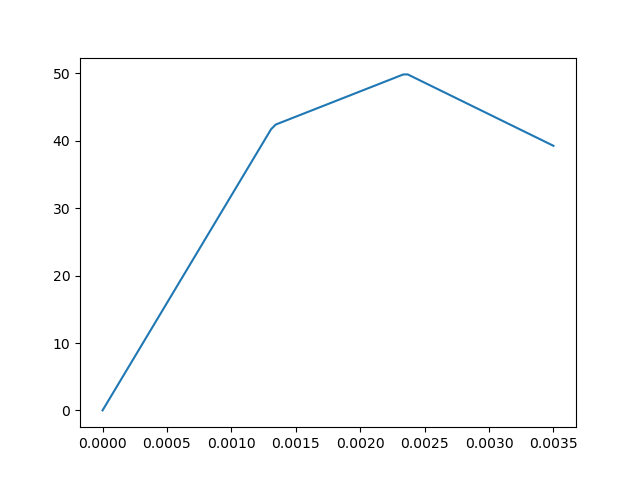

In [17]:
get_eq = sp.lambdify(eps, eq.subs({f_cm:50, E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8), eps_cu1:EC2.get_eps_cu1(50-8)}), 'numpy')
eps_vals = np.linspace(0, EC2.get_eps_cu1(50-8), 100)
sig_vals = get_eq(eps_vals)
fig4, ax4 = plt.subplots()
ax4.plot(eps_vals, sig_vals)

In [18]:
np.trapz(y=sig_vals, x=eps_vals)

0.12661394150900968

In [19]:
eq_area = sp.integrate(sp.simplify(eq), eps)
eq_area

Piecewise((varepsilon**2*(106872662337276115047134009155*E_cc*f_cm*varepsilon_cy - 57316659412989744540393551270*f_cm**2)/(110987770307626160534291925766*E_cc*varepsilon_cy**2 - 23697491119916817723943793176*f_cm*varepsilon_cy), varepsilon <= 0.563123356969542*varepsilon_cy), (varepsilon**2*(-24978224602818845141402027465*E_cc*f_cm*varepsilon_cy + 108826621269427233621180653810*f_cm**2)/(258316213895140518397124222702*E_cc*varepsilon_cy**2 - 55154240579333546828168620472*f_cm*varepsilon_cy) + varepsilon*(154136331550389104339964138816*E_cc*f_cm*varepsilon_cy - 136403741559094007035264964046*f_cm**2)/(129158106947570259198562111351*E_cc*varepsilon_cy - 27577120289666773414084310236*f_cm) - 0.317107915164646*varepsilon_cy**2*(-24978224602818845141402027465*E_cc*f_cm*varepsilon_cy + 108826621269427233621180653810*f_cm**2)/(258316213895140518397124222702*E_cc*varepsilon_cy**2 - 55154240579333546828168620472*f_cm*varepsilon_cy) + 0.317107915164646*varepsilon_cy**2*(1068726623372761150471340

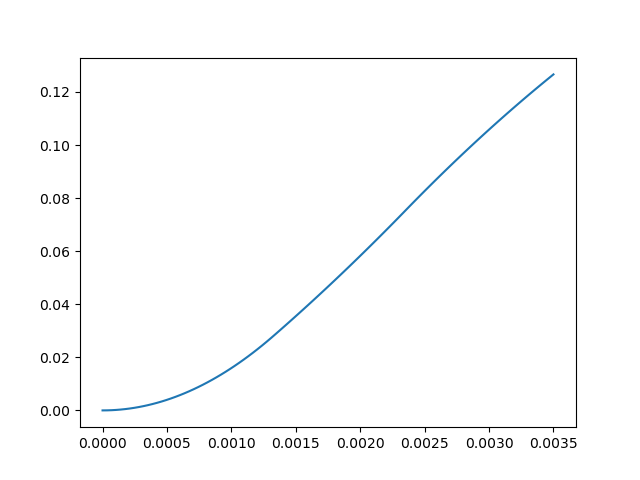

In [20]:
get_eq_area = sp.lambdify(eps, eq_area.subs({f_cm:50, E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8), eps_cu1:EC2.get_eps_cu1(50-8)}), 'numpy')
eps_vals2 = np.linspace(0, EC2.get_eps_cu1(50-8), 100)
sig_vals2 = get_eq_area(eps_vals2)
fig4, ax4 = plt.subplots()
ax4.plot(eps_vals2, sig_vals2)

In [21]:
sig_1_area_up_to_eps = eq_area.args[0][0]
sig_2_area_up_to_eps = eq_area.args[1][0]
sig_3_area_up_to_eps = eq_area.args[2][0]
sig_1_area_up_to_eps

varepsilon**2*(106872662337276115047134009155*E_cc*f_cm*varepsilon_cy - 57316659412989744540393551270*f_cm**2)/(110987770307626160534291925766*E_cc*varepsilon_cy**2 - 23697491119916817723943793176*f_cm*varepsilon_cy)

In [22]:
# Compare F_t = A_f * f_fu with F_c_1, if F_t <= F_c_1, then you can use sig_c_part_1
eps_fu = f_fu/E_f
c_1 = d * (eps_cy_p1 / (eps_cy_p1 + eps_fu))
F_c_1 = sig_1_area_up_to_eps.subs({eps:eps_cy_p1}) * (c_1 / eps_cy_p1) * b
F_c_1 = sp.simplify(F_c_1)
F_c_1

122.140185528316*E_f*d*f_cm*varepsilon_cy*(591279524818019*E_cc*varepsilon_cy - 317107915164646*f_cm)/((591279524818019*E_cc*varepsilon_cy - 126246713939084*f_cm)*(0.563123356969542*E_f*varepsilon_cy + f_{fu}))

In [23]:
20*2500

50000

In [24]:
sp.N(F_c_1.subs({f_cm:50, b:400, d:180, f_fu:2500, E_f:200000, E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8)}))

145916.655551842

In [25]:
# Compare F_t = A_f * f_fu with F_c_1, if F_t <= F_c_1, then you can use sig_c_part_1
eps_fu = f_fu/E_f
c_2 = d * (eps_c1 / (eps_c1 + eps_fu))
F_c_2 = sig_2_area_up_to_eps.subs({eps:eps_c1}) * (c_2 / eps_c1) * b
F_c_2 = sp.simplify(F_c_2)
F_c_2

# You don't need F_c_3 because if F_t > F_c_2, then the user will use last equation directly

100*E_f*d*f_cm*varepsilon_cy*(8.05686918235794e+57*E_cc*varepsilon_cy - 3.57414222936842e+57*f_cm)/(4478266681224077699188638243396683236215337*(591279524818019*E_cc*varepsilon_cy - 126246713939084*f_cm)*(E_f*varepsilon_cy + f_{fu}))

In [26]:
# Solving eps top for part 1
def get_eps_top_solved(index):
    c = d * eps/(eps + eps_fu)

    F_t = A_f * f_fu
    sig_z_area = eq_area.args[index][0] * (c / eps)
    F_c = sig_z_area * b
    eps_top_solved = sp.solve(F_t - F_c, eps)[1] # TODO, this the positive solution, make sure you don't want the negative
    eps_top_solved = sp.simplify(eps_top_solved)
    return eps_top_solved

In [27]:
eps_part_1 = get_eps_top_solved(0)
eps_part_1

f_{fu}*(sqrt(93853892828257)*sqrt(A_f)*sqrt(varepsilon_cy)*sqrt(32812398044052317324968879879032381103588777*A_f*E_cc**2*E_f*varepsilon_cy**3 - 14011841288763640891831484749582505974038344*A_f*E_cc*E_f*f_cm*varepsilon_cy**2 + 1495865191245060910962005070346931779445392*A_f*E_f*f_cm**2*varepsilon_cy + 50553293602256973707291923881697245803971156000*E_cc**2*d*f_cm*varepsilon_cy**2 - 37905991657496980897223254044829471411718520000*E_cc*d*f_cm**2*varepsilon_cy + 5788831923884498031297954268964330568669344000*d*f_cm**3) + 93853892828257*A_f*sqrt(E_f)*varepsilon_cy*(591279524818019*E_cc*varepsilon_cy - 126246713939084*f_cm))/(72299247886298000*sqrt(E_f)*d*f_cm*(591279524818019*E_cc*varepsilon_cy - 317107915164646*f_cm))

In [28]:
def get_psi(index):
    if index >= 2:
        return 1
    else:
        eps_top_solved = get_eps_top_solved(index)
        sig_c_eq = eq.args[index][0]
        f_c_max = sig_c_eq.subs({eps: eps_top_solved})
        psi_c = f_c_max/f_cm
        psi_c = sp.simplify(psi_c)
        return psi_c

In [29]:
psi_c_part_1 = get_psi(0)
# sp.cse(psi_c_part_1)
psi_c_part_1

f_{fu}*(sqrt(93853892828257)*sqrt(A_f)*sqrt(varepsilon_cy)*sqrt(32812398044052317324968879879032381103588777*A_f*E_cc**2*E_f*varepsilon_cy**3 - 14011841288763640891831484749582505974038344*A_f*E_cc*E_f*f_cm*varepsilon_cy**2 + 1495865191245060910962005070346931779445392*A_f*E_f*f_cm**2*varepsilon_cy + 50553293602256973707291923881697245803971156000*E_cc**2*d*f_cm*varepsilon_cy**2 - 37905991657496980897223254044829471411718520000*E_cc*d*f_cm**2*varepsilon_cy + 5788831923884498031297954268964330568669344000*d*f_cm**3) + 93853892828257*A_f*sqrt(E_f)*varepsilon_cy*(591279524818019*E_cc*varepsilon_cy - 126246713939084*f_cm))/(37541557131302800*sqrt(E_f)*d*f_cm*varepsilon_cy*(591279524818019*E_cc*varepsilon_cy - 126246713939084*f_cm))

In [30]:
sp.N(psi_c_part_1.subs({f_cm:50, b:400, d:180, f_fu:2500, E_f:200000, A_f:20, E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8)}))

0.484722259071172

In [44]:
# Because first part is triangle, the center of it is
ce1 = c.subs({eps: eps_part_1}) / 3
ce1 = sp.simplify(ce1)
ce1

E_f*d*(sqrt(93853892828257)*sqrt(A_f)*sqrt(varepsilon_cy)*sqrt(32812398044052317324968879879032381103588777*A_f*E_cc**2*E_f*varepsilon_cy**3 - 14011841288763640891831484749582505974038344*A_f*E_cc*E_f*f_cm*varepsilon_cy**2 + 1495865191245060910962005070346931779445392*A_f*E_f*f_cm**2*varepsilon_cy + 50553293602256973707291923881697245803971156000*E_cc**2*d*f_cm*varepsilon_cy**2 - 37905991657496980897223254044829471411718520000*E_cc*d*f_cm**2*varepsilon_cy + 5788831923884498031297954268964330568669344000*d*f_cm**3) + 93853892828257*A_f*sqrt(E_f)*varepsilon_cy*(591279524818019*E_cc*varepsilon_cy - 126246713939084*f_cm))/(3*(72299247886298000*sqrt(E_f)*d*f_cm*(591279524818019*E_cc*varepsilon_cy - 317107915164646*f_cm) + E_f*(sqrt(93853892828257)*sqrt(A_f)*sqrt(varepsilon_cy)*sqrt(32812398044052317324968879879032381103588777*A_f*E_cc**2*E_f*varepsilon_cy**3 - 14011841288763640891831484749582505974038344*A_f*E_cc*E_f*f_cm*varepsilon_cy**2 + 1495865191245060910962005070346931779445392*A_f*E_

In [45]:
M_n_1 = sp.simplify(A_f * f_fu * (d - ce1))
M_n_1
# packaging common terms
# sp.cse(M_n)

2*A_f*d*f_{fu}*(108448871829447000*sqrt(E_f)*d*f_cm*(591279524818019*E_cc*varepsilon_cy - 317107915164646*f_cm) + E_f*(sqrt(93853892828257)*sqrt(A_f)*sqrt(varepsilon_cy)*sqrt(32812398044052317324968879879032381103588777*A_f*E_cc**2*E_f*varepsilon_cy**3 - 14011841288763640891831484749582505974038344*A_f*E_cc*E_f*f_cm*varepsilon_cy**2 + 1495865191245060910962005070346931779445392*A_f*E_f*f_cm**2*varepsilon_cy + 50553293602256973707291923881697245803971156000*E_cc**2*d*f_cm*varepsilon_cy**2 - 37905991657496980897223254044829471411718520000*E_cc*d*f_cm**2*varepsilon_cy + 5788831923884498031297954268964330568669344000*d*f_cm**3) + 93853892828257*A_f*sqrt(E_f)*varepsilon_cy*(591279524818019*E_cc*varepsilon_cy - 126246713939084*f_cm)))/(3*(72299247886298000*sqrt(E_f)*d*f_cm*(591279524818019*E_cc*varepsilon_cy - 317107915164646*f_cm) + E_f*(sqrt(93853892828257)*sqrt(A_f)*sqrt(varepsilon_cy)*sqrt(32812398044052317324968879879032381103588777*A_f*E_cc**2*E_f*varepsilon_cy**3 - 1401184128876364089

In [46]:
sp.N(M_n_1.subs({f_cm:50, b:400, d:180, f_fu:2500, E_f:200000, A_f:20, E_cc:EC2.get_E_cm(50-8), eps_cy:EC2.get_eps_c1(50-8)}) / 1e6)

8.82808024229583

In [34]:
# Not solvable directly if eps_cy and E_cc are substituted, it's solved below, but it's very complex formula!
psi_c_part_2 = get_psi(1)
psi_c_part_2

(3.41819138593547e-39*E_cc*sqrt(E_f)*varepsilon_cy*(4.19802094165023e+25*E_cc*varepsilon_cy - 1.82901884486432e+26*f_cm)*(4.20168067226891e-6*sqrt(E_f)*varepsilon_cy*(1.2915810694757e+29*A_f*E_cc*f_{fu}*varepsilon_cy - 2.75771202896668e+28*A_f*f_cm*f_{fu} - 6.16545326201556e+31*E_cc*d*f_cm*varepsilon_cy + 5.45614966236376e+31*d*f_cm**2) - 2.94405650522421e+26*sqrt(varepsilon_cy)*sqrt(3.39779478603295e-6*A_f**2*E_cc**2*E_f*f_{fu}**2*varepsilon_cy**3 - 1.45095647108036e-6*A_f**2*E_cc*E_f*f_cm*f_{fu}**2*varepsilon_cy**2 + 1.54900075898047e-7*A_f**2*E_f*f_cm**2*f_{fu}**2*varepsilon_cy - 0.0032439225755624*A_f*E_cc**2*E_f*d*f_cm*f_{fu}*varepsilon_cy**3 - 0.000525686746736044*A_f*E_cc**2*d*f_cm*f_{fu}**2*varepsilon_cy**2 + 0.00356335031106778*A_f*E_cc*E_f*d*f_cm**2*f_{fu}*varepsilon_cy**2 + 0.00240258513420349*A_f*E_cc*d*f_cm**2*f_{fu}**2*varepsilon_cy - 0.000612941444163722*A_f*E_f*d*f_cm**3*f_{fu}*varepsilon_cy - 0.000489021383445285*A_f*d*f_cm**3*f_{fu}**2 + 0.703599487243633*E_cc**2*E_f*

In [35]:
psi_c_part_2_reduced = sp.cse(psi_c_part_2)
psi_c_part_2_reduced

([(x0, E_cc*varepsilon_cy),
  (x1, (-f_cm + 0.22952311035164*x0)**2),
  (x2, d*f_cm),
  (x3, E_f*varepsilon_cy),
  (x4, sqrt(E_f)),
  (x5, A_f*f_{fu}),
  (x6, f_cm*x5),
  (x7, f_cm**2),
  (x8, d*x7),
  (x9,
   varepsilon_cy*x4*(-6.16545326201556e+31*x0*x2 + 1.2915810694757e+29*x0*x5 - 2.75771202896668e+28*x6 + 5.45614966236376e+31*x8)),
  (x10, sqrt(varepsilon_cy)),
  (x11, f_{fu}**2),
  (x12, A_f*x11),
  (x13, f_cm**3),
  (x14, d*x13),
  (x15, E_f*d**2),
  (x16, A_f**2*x11),
  (x17, varepsilon_cy**2),
  (x18, E_cc*x17),
  (x19, E_cc**2),
  (x20, varepsilon_cy**3*x19),
  (x21, E_f*x16),
  (x22,
   sqrt(-0.0032439225755624*E_f*d*x20*x6 + 0.00356335031106778*E_f*x18*x5*x8 + 0.33393429324923*f_cm**4*varepsilon_cy*x15 - 1.45095647108036e-6*f_cm*x18*x21 + 0.00240258513420349*x0*x12*x8 - 0.000489021383445285*x12*x14 - 0.000525686746736044*x12*x17*x19*x2 - x13*x15*x18 - 0.000612941444163722*x14*x3*x5 + 0.703599487243633*x15*x20*x7 + 1.54900075898047e-7*x16*x3*x7 + 3.39779478603295e-6*x20*x21)

In [36]:
psi_c_part_3 = get_psi(2)
psi_c_part_3

1

## Solving psi and Mn for part 2 if it's not solvable because eps_cy and E_cc are substituted

In [37]:
eps_part_2 = get_eps_top_solved(1)
eps_part_2

(-4.20168067226891e-6*sqrt(E_f)*varepsilon_cy*(1.2915810694757e+29*A_f*E_cc*f_{fu}*varepsilon_cy - 2.75771202896668e+28*A_f*f_cm*f_{fu} - 6.16545326201556e+31*E_cc*d*f_cm*varepsilon_cy + 5.45614966236376e+31*d*f_cm**2) + 2.94405650522421e+26*sqrt(varepsilon_cy)*sqrt(3.39779478603295e-6*A_f**2*E_cc**2*E_f*f_{fu}**2*varepsilon_cy**3 - 1.45095647108036e-6*A_f**2*E_cc*E_f*f_cm*f_{fu}**2*varepsilon_cy**2 + 1.54900075898047e-7*A_f**2*E_f*f_cm**2*f_{fu}**2*varepsilon_cy - 0.0032439225755624*A_f*E_cc**2*E_f*d*f_cm*f_{fu}*varepsilon_cy**3 - 0.000525686746736044*A_f*E_cc**2*d*f_cm*f_{fu}**2*varepsilon_cy**2 + 0.00356335031106778*A_f*E_cc*E_f*d*f_cm**2*f_{fu}*varepsilon_cy**2 + 0.00240258513420349*A_f*E_cc*d*f_cm**2*f_{fu}**2*varepsilon_cy - 0.000612941444163722*A_f*E_f*d*f_cm**3*f_{fu}*varepsilon_cy - 0.000489021383445285*A_f*d*f_cm**3*f_{fu}**2 + 0.703599487243633*E_cc**2*E_f*d**2*f_cm**2*varepsilon_cy**3 - E_cc*E_f*d**2*f_cm**3*varepsilon_cy**2 + 0.33393429324923*E_f*d**2*f_cm**4*varepsilon_cy

In [38]:
c = d * eps/(eps + eps_fu)

F_t = A_f * f_fu
sig_z_area = eq_area.args[1][0] * (c / eps)
factors, sig_z_area = sp.cse(sig_z_area)[:-1][0], sp.cse(sig_z_area)[-1][0]
sig_z_area

d*(varepsilon**2*x7 + varepsilon*x3 - 0.563123356969542*varepsilon_cy*x3 - x7*x8 + x8*(-57316659412989744540393551270*x1 + 106872662337276115047134009155*x2)/(-23697491119916817723943793176*x4 + 110987770307626160534291925766*x6))/(varepsilon + f_{fu}/E_f)

In [39]:
F_c = sig_z_area * b
eps_top_solved = sp.solve(F_t - F_c, eps)[0] # TODO, this the positive solution, make sure you don't want the negative
eps_top_solved

(0.00125*sqrt(E_f)*(126246713939084.0*x4 - 591279524818019.0*x6)*(A_f*f_{fu} - 400.0*d*x3) - 591279524818019.0*sqrt(7.12318971073823e-8*A_f**2*E_f*f_{fu}**2*x4**2 - 6.67232610804613e-7*A_f**2*E_f*f_{fu}**2*x4*x6 + 1.5625e-6*A_f**2*E_f*f_{fu}**2*x6**2 - 5.69855176859059e-5*A_f*E_f*d*f_{fu}*x3*x4**2 + 0.00053378608864369*A_f*E_f*d*f_{fu}*x3*x4*x6 - 0.00125*A_f*E_f*d*f_{fu}*x3*x6**2 + 0.000113971035371812*A_f*d*f_{fu}**2*x4**2*x7 - 0.00106757217728738*A_f*d*f_{fu}**2*x4*x6*x7 + 0.0025*A_f*d*f_{fu}**2*x6**2*x7 + 0.0256719008143476*E_f*d**2*varepsilon_cy*x3*x4**2*x7 - 0.240469931312541*E_f*d**2*varepsilon_cy*x3*x4*x6*x7 + 0.563123356969542*E_f*d**2*varepsilon_cy*x3*x6**2*x7 - 0.110263807831736*E_f*d**2*x1*x4*x7*x8 + 0.516423199187843*E_f*d**2*x1*x6*x7*x8 + 0.205597933011301*E_f*d**2*x2*x4*x7*x8 - 0.962922870159981*E_f*d**2*x2*x6*x7*x8 + 0.0113971035371812*E_f*d**2*x3**2*x4**2 - 0.106757217728738*E_f*d**2*x3**2*x4*x6 + 0.25*E_f*d**2*x3**2*x6**2 + 0.0455884141487247*E_f*d**2*x4**2*x7**2*x8 - 

In [40]:
sig_c_eq = eq.args[1][0]
f_c_max = sig_c_eq.subs({eps: eps_top_solved})
psi_c = f_c_max/f_cm
psi_c

(154136331550389104339964138816*E_cc*varepsilon_cy**2 - 24978224602818845141402027465*E_cc*varepsilon_cy*(0.00125*sqrt(E_f)*(126246713939084.0*x4 - 591279524818019.0*x6)*(A_f*f_{fu} - 400.0*d*x3) - 591279524818019.0*sqrt(7.12318971073823e-8*A_f**2*E_f*f_{fu}**2*x4**2 - 6.67232610804613e-7*A_f**2*E_f*f_{fu}**2*x4*x6 + 1.5625e-6*A_f**2*E_f*f_{fu}**2*x6**2 - 5.69855176859059e-5*A_f*E_f*d*f_{fu}*x3*x4**2 + 0.00053378608864369*A_f*E_f*d*f_{fu}*x3*x4*x6 - 0.00125*A_f*E_f*d*f_{fu}*x3*x6**2 + 0.000113971035371812*A_f*d*f_{fu}**2*x4**2*x7 - 0.00106757217728738*A_f*d*f_{fu}**2*x4*x6*x7 + 0.0025*A_f*d*f_{fu}**2*x6**2*x7 + 0.0256719008143476*E_f*d**2*varepsilon_cy*x3*x4**2*x7 - 0.240469931312541*E_f*d**2*varepsilon_cy*x3*x4*x6*x7 + 0.563123356969542*E_f*d**2*varepsilon_cy*x3*x6**2*x7 - 0.110263807831736*E_f*d**2*x1*x4*x7*x8 + 0.516423199187843*E_f*d**2*x1*x6*x7*x8 + 0.205597933011301*E_f*d**2*x2*x4*x7*x8 - 0.962922870159981*E_f*d**2*x2*x6*x7*x8 + 0.0113971035371812*E_f*d**2*x3**2*x4**2 - 0.1067572

In [41]:
# substitute factors in each others
# convert factors list of tuples to list of lists so that expressions can be modified

factors = [[symb, value] for (symb, value) in factors]
for i in range(len(factors)):
    factors[i][1] = factors[i][1].subs({symb:value for (symb, value) in factors})
factors

[[x0, E_cc*varepsilon_cy],
 [x1, f_cm**2],
 [x2, E_cc*f_cm*varepsilon_cy],
 [x3,
  (154136331550389104339964138816*E_cc*f_cm*varepsilon_cy - 136403741559094007035264964046*f_cm**2)/(129158106947570259198562111351*E_cc*varepsilon_cy - 27577120289666773414084310236*f_cm)],
 [x4, f_cm*varepsilon_cy],
 [x5, varepsilon_cy**2],
 [x6, E_cc*varepsilon_cy**2],
 [x7,
  (-24978224602818845141402027465*E_cc*f_cm*varepsilon_cy + 108826621269427233621180653810*f_cm**2)/(258316213895140518397124222702*E_cc*varepsilon_cy**2 - 55154240579333546828168620472*f_cm*varepsilon_cy)],
 [x8, 0.317107915164646*varepsilon_cy**2]]

In [42]:
psi_c = psi_c.subs({symb:value for (symb, value) in factors})
psi_c = sp.simplify(psi_c)
psi_c

NameError: name 'factors_list' is not defined

In [ ]:
psi_c_reduced = sp.cse(psi_c)
psi_c_reduced[-1][0]